# Testing single qubit gates

## Importing relevant modules

In [110]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'axes.labelsize' : 12,})

import copy
from scipy.interpolate import interp1d

#potential module
import qudipy.potential as pot

# for solving Schrod eq-n and Stark shift stuff
import qudipy.qutils as qt
import qudipy.starkshift as ss

#Spin simulator module
import qudipy.spinsimulator.spin_simulator as sps
#Constant pulse generating module
import qudipy.spinsimulator.pulse_generators as pulsegens

#Circuit module containing control pulses and ideal circuits
import qudipy.circuit as circ


#Control shapes and voltage pulse routines
from qudipy.control import shapes, voltage_pulses

#Constants class
from qudipy.utils.constants import Constants
from scipy.constants import e,m_e

## Voltage pulse parameters

Defining the system constants


In [111]:
csts = Constants('Si/SiO2')


Defining the voltage parameters and creating pulse shapes

In [112]:
V_0 = 0.65  # pulse amplitude, V
dV = 0.5    # offset, V

f_rf = 17e9                             # ESR resonator frequency, Hz

# normalized time points
tau = np.linspace(0, 1, 100)

# creating 4 testing pulses of different shapes for 0 < tau < 1 
unit_square = shapes.square(amp=V_0, offset=dV)
unit_triangle = shapes.triangle(amp=V_0, offset=dV)

unit_wide_gauss = shapes.shifted_gauss(amp=V_0, offset=dV, sigma=0.4)
unit_narrow_gauss = shapes.shifted_gauss(amp=V_0, offset=dV, sigma=0.1)


Plotting the shapes for a wider time range than needed
 to make sure the offset is specified correctly.

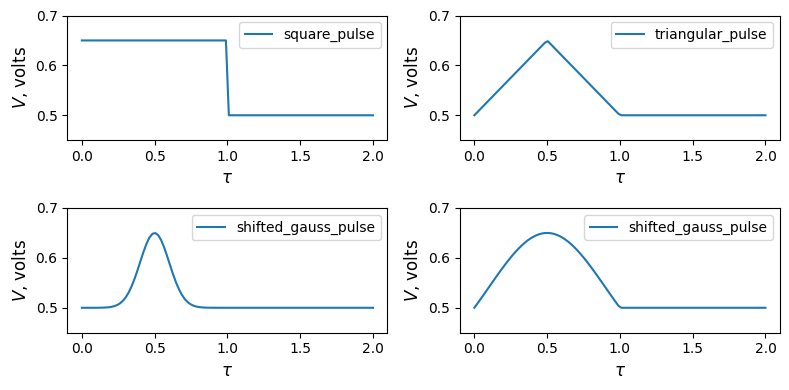

In [113]:
unit_shapes = (unit_square, unit_triangle, unit_narrow_gauss, unit_wide_gauss)

fig, ax = plt.subplots(2,2, figsize=(8,4), dpi=100)
for i, shape in enumerate(unit_shapes):
    ax[i//2, i%2].plot(tau * 2, shape(tau * 2), label=shape.__name__)
    ax[i//2, i%2].legend()
    
    #setting axes labels
    ax[i//2, i%2].set_xlabel('$\\tau$', size=12)
    ax[i//2, i%2].set_ylabel('${V}$, volts', size=12)

    ax[i//2, i%2].set_ylim((0.45,0.7))

fig.tight_layout()
plt.show()

## Getting ROT gates with dummy interpolation $\delta g(V)$

At first, we specify a dummy linear dependency between $\delta g$ and V.

In [114]:
delta_g_dummy = lambda V: 0.01 * V - 0.002

Now, we are ready to import the correct data

In [115]:
input_nextnano = os.path.join(sys.path[0],'QuDiPy tutorial data','Nextnano simulations','1_dot_P_0p5_0p7')
output_preprocessed = os.path.join(sys.path[0],'QuDiPy tutorial data','Pre-processed potentials','Pre-processed_data')

#importing potential
potential = pot.process_nextnano.import_folder(input_nextnano, option=True)


Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.5\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.525\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.55\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.575\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.6\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.625\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.65\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.675\output\bias_000_000_000:
Importing .coord and .dat data files from \1_dot_P_0p5_0p7_t2_VP_0.7\output\bias_000_000_000:


In [116]:
#finding the right z coordinate
coord = potential[0][2]
z = coord[2][59]
z

-0.2

Constructing a z-slice for the data

In [117]:

#specifying control values and names
pot_dir = output_preprocessed + '_for_slice_{:.3e}'.format(z) + '\\'

ctrl_names = ['VP']

ctrl_vals = pot.process_nextnano.retrieve_ctrl_vals(potential)
ctrl_vals

[[0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7]]

In [118]:

# Now we define the field types we wish to write 2D slices for. Either potential or the electric field.
pot.process_nextnano.write_data(input_nextnano,output_preprocessed, slice=z, f_type=['potential','field'])


Converting 3D nextnano simulation data too 2D XY-plane potential along slice for z = -0.2.
Converting 3D nextnano simulation data too 2D XY-plane field along slice for z = -0.2.


(0,
 array([[ 0.00000000e+00, -5.00000000e+01, -4.40000000e+01, ...,
          4.00000000e+01,  4.40000000e+01,  5.00000000e+01],
        [-6.00000000e+01, -9.37390724e-04, -9.41386464e-04, ...,
         -9.48169616e-04, -9.41386464e-04, -9.37390724e-04],
        [-5.48252222e+01, -9.50829142e-04, -9.55162302e-04, ...,
         -9.62518539e-04, -9.55162302e-04, -9.50829142e-04],
        ...,
        [ 9.03836505e+01, -8.08917442e-04, -8.57526837e-04, ...,
         -9.24629577e-04, -8.57526837e-04, -8.08917442e-04],
        [ 9.50241724e+01, -8.18322568e-04, -8.67917793e-04, ...,
         -9.36332156e-04, -8.67917792e-04, -8.18322569e-04],
        [ 1.00000000e+02, -8.21740640e-04, -8.71688016e-04, ...,
         -9.40571561e-04, -8.71688016e-04, -8.21740640e-04]]))

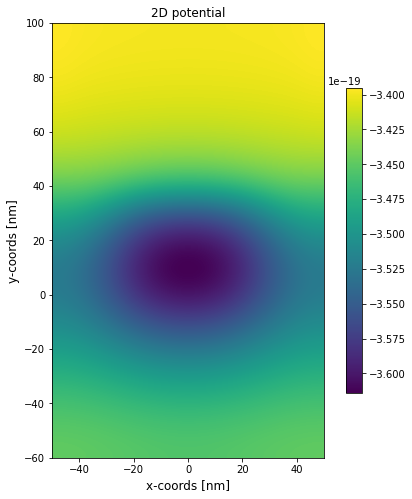

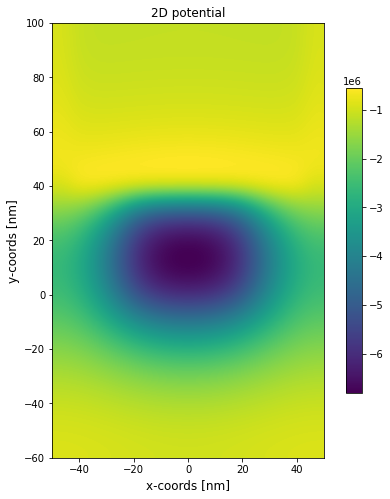

In [119]:
loaded_data_pot = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='pot', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='eV')

loaded_data_field = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='electric', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='V/nm')

potential_int = pot.build_interpolator(loaded_data_pot,
                                         constants=csts)
e_field_int = pot.build_interpolator(loaded_data_field,
                                         constants=csts)

potential_int.plot([0.65])
e_field_int.plot([0.65])

## True g(V)
Now we create a ''true'' g-factor dependency on voltage.
First, create a Grid Parameters object:

In [120]:
# Construct a GridParameters object

_2d_coords = loaded_data_pot['coords']
gparams = pot.GridParameters(_2d_coords.x, _2d_coords.y)
len(loaded_data_pot['potentials'])

9

In [121]:
def true_g_data(grapams, pot_data, e_field_data):
    delta_g_vals = []
    for idx, param in enumerate(pot_data['ctrl_vals']):
        new_pot = pot_data['potentials'][idx]
        gparams.update_potential(new_pot)
        _, e_vecs = qt.solvers.solve_schrodinger_eq(csts, gparams, n_sols=1)
        wf = e_vecs[:,:,0]
        stark_shift = ss.starkshift.StarkShift(gparams, csts)
            #lambda to do the g-factor of discrete data rather than interpolated

        dummy_e_int = lambda V: e_field_data['electric'][
                        np.nonzero(np.array(ctrl_vals[0]) == V[0])[0][0]]

        dg = stark_shift.delta_g(dummy_e_int, [param], ctrl_names,
                                             wavefuncs=[wf])['delta_g_1'][0]
        delta_g_vals.append(dg) 
    return interp1d(np.array(ctrl_vals[0]), delta_g_vals)


delta_g_true = true_g_data(gparams, loaded_data_pot, loaded_data_field)



Plotting $\delta g (V)$ function

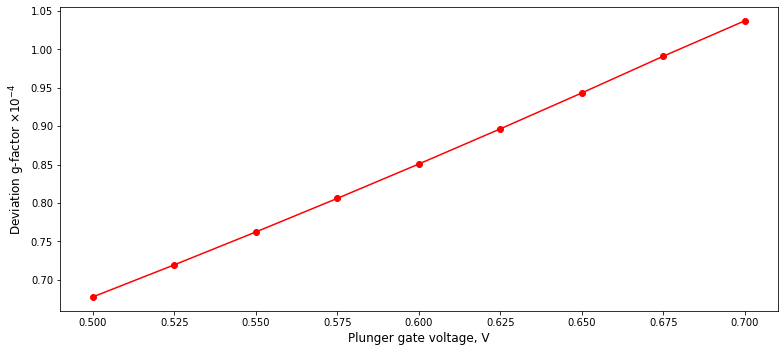

In [122]:

fig, ax = plt.subplots(figsize=(11,5))

ax.plot(ctrl_vals[0], delta_g_true(ctrl_vals[0]) * 1e4, 'r-o' )
ax.set_xlabel('Plunger gate voltage, V')
ax.set_ylabel('Deviation g-factor $\\times 10^{-4}$')

fig.tight_layout()

In [123]:
def true_g_def(gparams, pot_interp, field_interp):
    def delta_g(V):
        new_pot = pot_interp([V])
        gparams.update_potential(new_pot)
        e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(csts, gparams, n_sols=1)
        wf = e_vecs[:,:,0]
        # pot_interp.plot([V], plot_type='1D', y_slice=0, show_wf=True)
        stark_shift = ss.starkshift.StarkShift(gparams, csts)
        dg = stark_shift.delta_g(field_interp, [[V]], ctrl_names, wavefuncs=[wf])['delta_g_1'][0]
        return dg
    return np.vectorize(delta_g)


## Specifying spin system parameters

Now we find the value of Zeeman field that ensures no spin rotation during idling

In [124]:
B_0 = voltage_pulses.balance_zeeman(delta_g_true, dV, f_rf)

f_larmor = e / m_e * B_0/(2 * np.pi )
print('B_0: {} T, \nLarmor frequency: {} GHz.'.format(B_0, f_larmor / 1e9))
                                                   

B_0: 0.6072851719911174 T, 
Larmor frequency: 16.99942402657938 GHz.


In [125]:
# Qubits in a pure  |↑↓> state

psi_down = np.array([0,1])
psi_up = np.array([1,0]) 

params_rabi = { "f_rf":f_rf, 'B_0':B_0 }    #"T_1":2e-4, "T_2":5e-6,

# creating a spin system; Zeeman field is yet to be specified
n_qubits = 2
rabi_system = sps.SpinSys((psi_up, psi_down), time=0, **params_rabi)
rho_initial = rabi_system.rho

Now we are generating the ROTZ and ROTX pulses on the 1st qubit when 
the other one is inactive.
Choose the "narrow gaussian" pulse for now

In [126]:
active_qubits = (1,)
rotx90_narrow_gauss = voltage_pulses.rot('x', 90, n_qubits, active_qubits,
                        delta_g_true, unit_narrow_gauss, B_0)

rotz90_narrow_gauss = voltage_pulses.rot('z', 90, n_qubits, active_qubits, 
                delta_g_true, unit_narrow_gauss, B_0)

roty_m90_narrow_gauss = voltage_pulses.rot('y', -90, n_qubits, active_qubits, 
                delta_g_true, unit_narrow_gauss, B_0)


triple_rot_sequence = [rotx90_narrow_gauss, rotz90_narrow_gauss, 
                        roty_m90_narrow_gauss]


Plotting control variables over time: joining pulses first


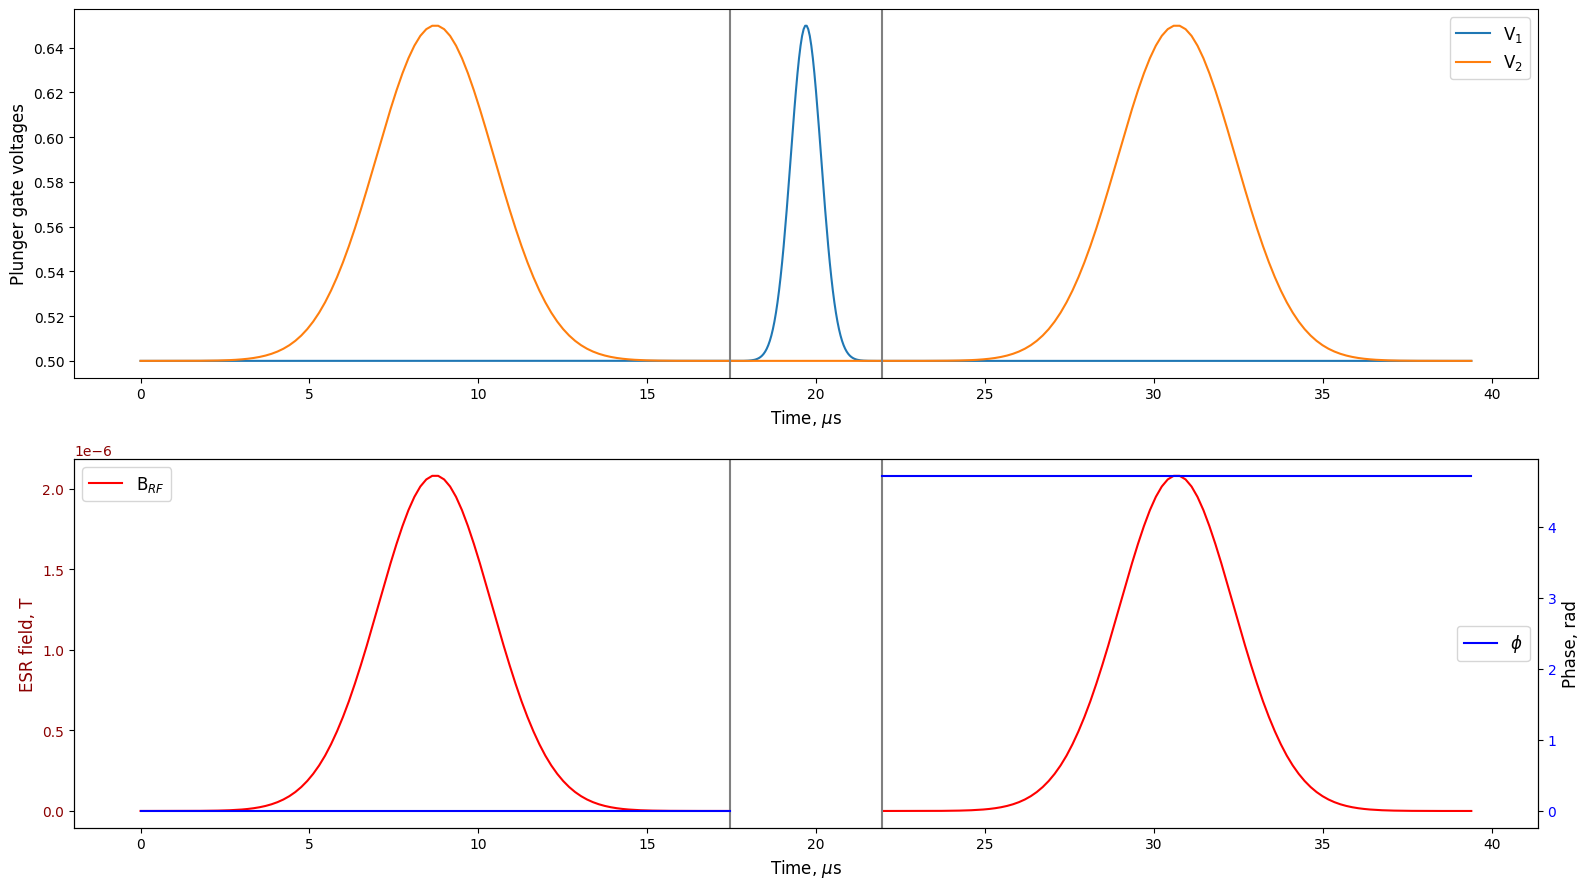

In [143]:
df1 = pd.DataFrame(rotx90_narrow_gauss.ctrl_pulses)
df2 = pd.DataFrame(rotz90_narrow_gauss.ctrl_pulses)
df3 = pd.DataFrame(roty_m90_narrow_gauss.ctrl_pulses)

joined_pulses = pd.concat([df1, df2, df3])

time1 = rotx90_narrow_gauss.ctrl_time
time2 = rotx90_narrow_gauss.length + rotz90_narrow_gauss.ctrl_time
time3 = (rotx90_narrow_gauss.length + rotz90_narrow_gauss.length +
                                        roty_m90_narrow_gauss.ctrl_time)

joined_time = np.concatenate((time1, time2, time3))

# plotting

fig, ax = plt.subplots(2, 1,figsize=(16,9), dpi=100)

mus_time = joined_time * 1e6        #in microseconds


###### Voltage pulses #######
ax[0].plot(mus_time, joined_pulses['V_1'] , label='V$_{1}$')
ax[0].plot(mus_time, joined_pulses['V_2'] , label='V$_{2}$')

ax[0].legend( fontsize='large')
ax[0].set_xlabel("Time, $\mu$s")
ax[0].set_ylabel("Plunger gate voltages")

###### ESR field pulses  #######

ax[1].plot(mus_time, joined_pulses['B_rf'], 
                color='red', label='B$_{RF}$')

ax[1].legend(loc='upper left', fontsize='large')
ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("ESR field, T", color='darkred')

ax[1].tick_params(axis='y', labelcolor='darkred')

####### Plotting phase on the same plot

ax_phase = ax[1].twinx()
ax_phase.plot(mus_time, joined_pulses['phi'] * np.pi / 180, 
                color='blue', label='$\phi$' )

ax_phase.legend(loc='center right',fontsize='large')
ax_phase.set_ylabel("Phase, rad")

ax_phase.tick_params(axis='y', labelcolor='blue')


#vertical lines showing borders between pulses
for axis in ax:
    axis.axvline(rotx90_narrow_gauss.length*1e6, c='gray' )
    axis.axvline((rotx90_narrow_gauss.length+ rotz90_narrow_gauss.length)*1e6, c='gray')


fig.tight_layout()


In [128]:
# B_rf = m_e / e * (np.pi * f_larmor) * (delta_g_true(unit_triangle(0.5)) - delta_g_true(unit_triangle(0)))
# simple_rotz_square = pulsegens.rot_square(active_qubits, n_qubits, 'Z', 90, B_0, 
#     B_rf = B_rf, f_rf=f_rf, delta_g=1e-3, num_val=50
# )
# simple_rotx_square = pulsegens.rot_square(active_qubits, n_qubits, 'X', 90, B_0, 
#     B_rf = B_rf, f_rf=f_rf, delta_g=1e-3, num_val=50
# )


Evolving the system under the pulses: two rotations along x must 
make the state equal to |spin-down spin-down>

In [129]:
rabi2 = copy.deepcopy(rabi_system) 

triple_rot = rabi2.evolve(triple_rot_sequence,     
                               rho_reference = rho_initial, eval_fidelity=True, 
                               track_qubits=(1,2), eval_Bloch_vectors=True, 
                                track_points_per_pulse=50)


ROTY_-90, step 100: 100%|██████████| 100/100 [00:00<00:00, 423.72it/s]


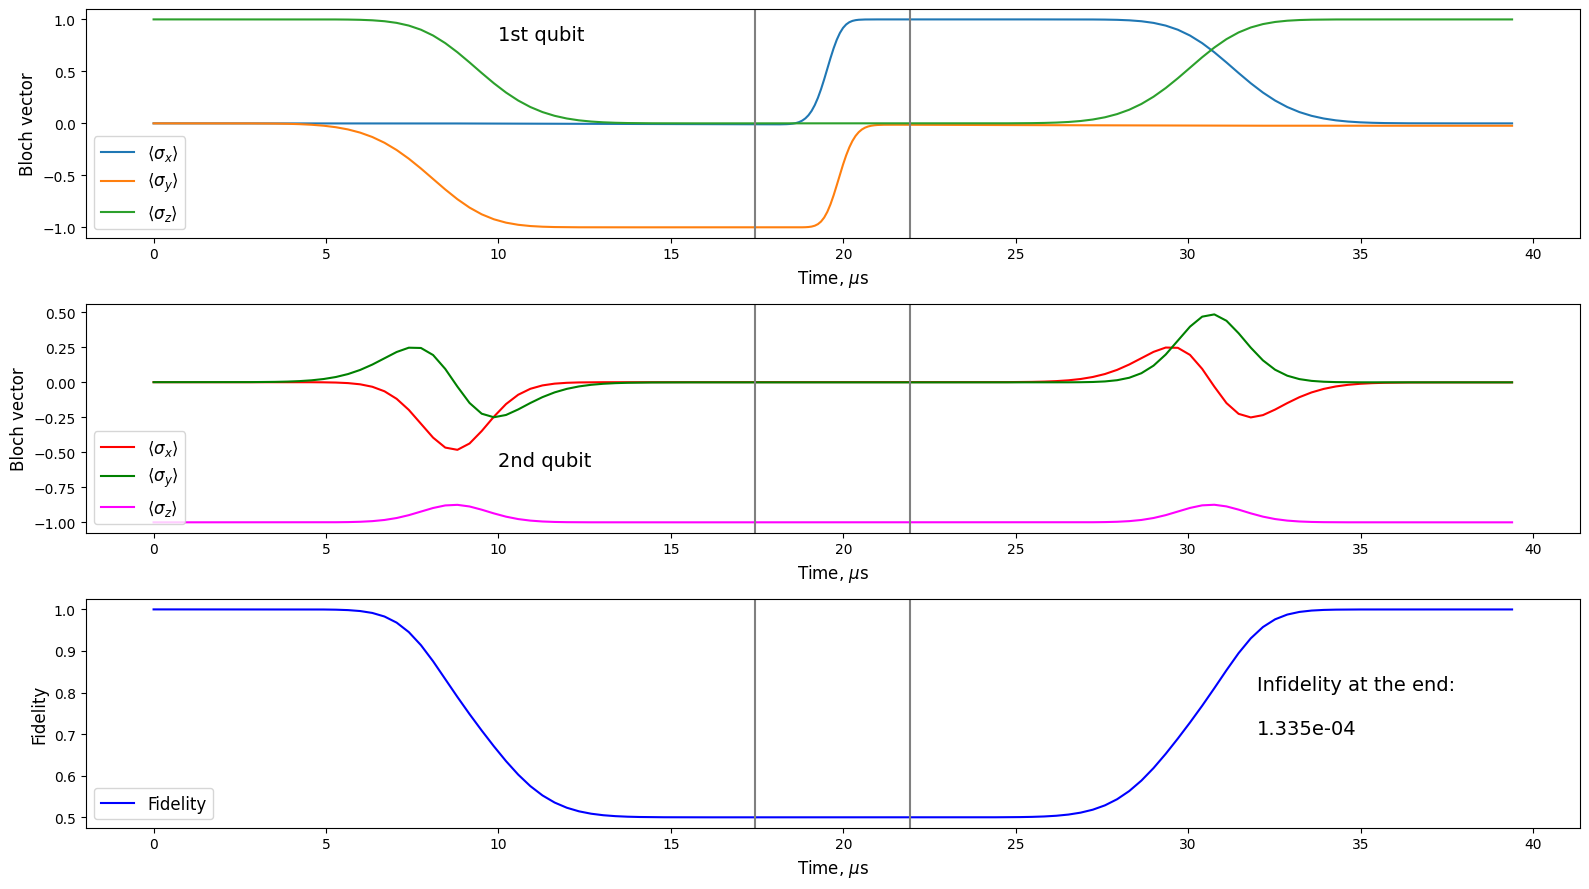

In [130]:
#plotting the evolution
fig, ax = plt.subplots(3, 1,figsize=(16,9), dpi=100)

mus_time = triple_rot["time"] * 1e6


###### Bloch vector of the 1st qubit #######
ax[0].plot(mus_time, np.real(triple_rot["sigma_x_1"]) , label='⟨$\sigma_x$⟩')
ax[0].plot(mus_time, np.real(triple_rot["sigma_y_1"]) , label='⟨$\sigma_y$⟩')
ax[0].plot(mus_time, np.real(triple_rot["sigma_z_1"]) , label='⟨$\sigma_z$⟩')

ax[0].legend(loc='lower left', fontsize='large')
ax[0].set_xlabel("Time, $\mu$s")
ax[0].set_ylabel("Bloch vector")

ax[0].text(10, 0.8, '1st qubit', fontsize=14,)

###### Bloch vector of the 2nd qubit #######
ax[1].plot(mus_time, np.real(triple_rot["sigma_x_2"]) , color='red', label='⟨$\sigma_x$⟩', )
ax[1].plot(mus_time, np.real(triple_rot["sigma_y_2"]) , color='green',  label='⟨$\sigma_y$⟩', )
ax[1].plot(mus_time, np.real(triple_rot["sigma_z_2"]) , color='magenta', label='⟨$\sigma_z$⟩')

ax[1].legend(loc='lower left', fontsize='large')
ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("Bloch vector")

ax[1].text(10, -0.6, '2nd qubit', fontsize=14,)


##### Plotting fidelity

ax[2].plot(mus_time, triple_rot['fidelity'], 'b-', label='Fidelity')
ax[2].set_xlabel("Time, $\mu$s")
ax[2].set_ylabel("Fidelity")
ax[2].legend( fontsize='large')

ax[2].text(32, 0.7,
            'Infidelity at the end: \n\n{:.3e}'.format(1-triple_rot['fidelity'][-1]),
                         fontsize=14, )

#vertical lines showing borders between pulses
for axis in ax:
    axis.axvline(rotx90_narrow_gauss.length*1e6, c='gray' )
    axis.axvline((rotx90_narrow_gauss.length+ rotz90_narrow_gauss.length)*1e6, c='gray')
fig.tight_layout()

In [131]:
#Testing the same thing for a simple pulse
rabi3 = copy.deepcopy(rabi_system) 

rotx90 = rabi3.evolve([simple_rotx_square, simple_rotz_square, 
                            simple_rotx_square] * 1,         
                               track_qubits=(1), eval_Bloch_vectors=True, 
                                track_points_per_pulse=50)

#plotting the results
fig, ax = plt.subplots(figsize=(11,5))

ax.plot(rotx90["time"], np.real(rotx90["sigma_x_1"]) , label='⟨$\sigma_x$⟩')
ax.plot(rotx90["time"], np.real(rotx90["sigma_y_1"]) , label='⟨$\sigma_y$⟩')
ax.plot(rotx90["time"], np.real(rotx90["sigma_z_1"]) , label='⟨$\sigma_z$⟩')

ax.legend(loc='lower left', fontsize='large')
plt.xlabel("Time, s")
plt.ylabel("Bloch vector components")

ax.grid()


NameError: name 'simple_rotx_square' is not defined